In [27]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import glob
from moviepy.editor import VideoFileClip
from IPython.display import HTML
%matplotlib inline

from keras.models import Sequential
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.core import Flatten, Dense, Activation, Reshape

from utils import load_weights, Box, yolo_net_out_to_car_boxes, draw_box

## the yolo model ##

In [28]:
# this is because we use tensorflow as the backend

# keras.backend.set_image_dim_ordering('th')

In [29]:
model = Sequential()
model.add(Convolution2D(16, 3, 3,input_shape=(3,448,448),border_mode='same',subsample=(1,1)))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Convolution2D(32,3,3 ,border_mode='same'))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D(pool_size=(2, 2),border_mode='valid'))
model.add(Convolution2D(64,3,3 ,border_mode='same'))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D(pool_size=(2, 2),border_mode='valid'))
model.add(Convolution2D(128,3,3 ,border_mode='same'))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D(pool_size=(2, 2),border_mode='valid'))
model.add(Convolution2D(256,3,3 ,border_mode='same'))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D(pool_size=(2, 2),border_mode='valid'))
model.add(Convolution2D(512,3,3 ,border_mode='same'))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D(pool_size=(2, 2),border_mode='valid'))
model.add(Convolution2D(1024,3,3 ,border_mode='same'))
model.add(LeakyReLU(alpha=0.1))
model.add(Convolution2D(1024,3,3 ,border_mode='same'))
model.add(LeakyReLU(alpha=0.1))
model.add(Convolution2D(1024,3,3 ,border_mode='same'))
model.add(LeakyReLU(alpha=0.1))
model.add(Flatten())
model.add(Dense(256))
model.add(Dense(4096))
model.add(LeakyReLU(alpha=0.1))
model.add(Dense(1470))

In [30]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_19 (Conv2D)           (None, 16, 448, 448)      448       
_________________________________________________________________
leaky_re_lu_21 (LeakyReLU)   (None, 16, 448, 448)      0         
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 16, 224, 224)      0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 32, 224, 224)      4640      
_________________________________________________________________
leaky_re_lu_22 (LeakyReLU)   (None, 32, 224, 224)      0         
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 32, 112, 112)      0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 64, 112, 112)      18496     
__________

load weight to the network

In [31]:
load_weights(model,'./yolo-tiny.weights')

## apply the model to images ##


In [32]:
imagePath = './test_images/test1.jpg'
image = plt.imread(imagePath)
image_crop = image[300:650,500:,:]
resized = cv2.resize(image_crop,(448,448))

In [33]:
batch = np.transpose(resized,(2,0,1))
batch = 2*(batch/255.) - 1
batch = np.expand_dims(batch, axis=0)
out = model.predict(batch)

interpolate the vector out from the neural network, generate the boxes

In [34]:
boxes = yolo_net_out_to_car_boxes(out[0], threshold = 0.17)

visualize the box on the original image

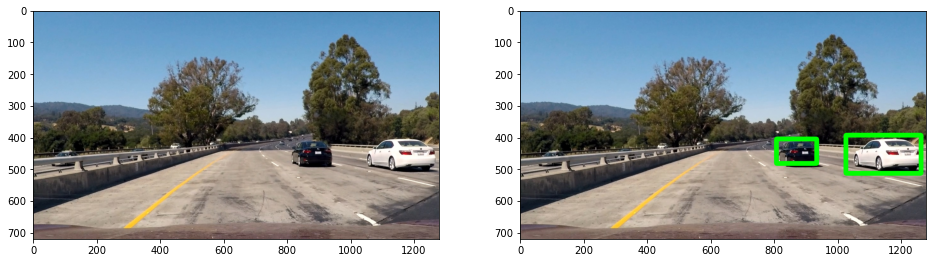

In [35]:
f,(ax1,ax2) = plt.subplots(1,2,figsize=(16,6))
ax1.imshow(image)
ax2.imshow(draw_box(boxes,plt.imread(imagePath),[[500,1280],[300,650]]))

other tests on images

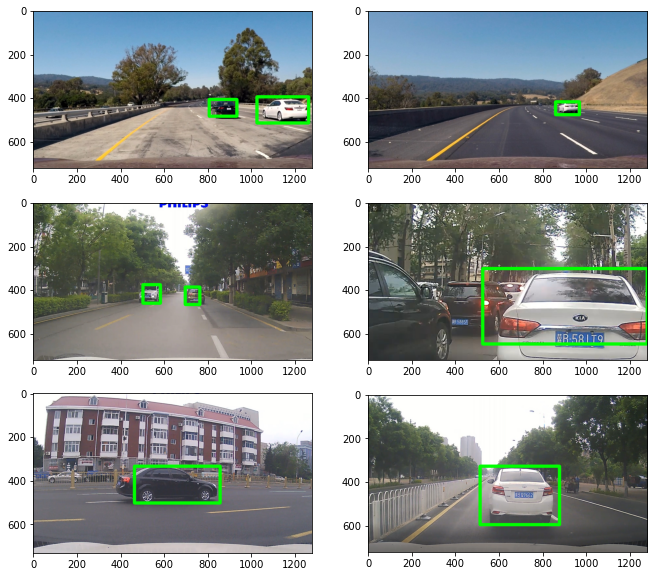

In [36]:
images = [plt.imread(file) for file in glob.glob('./test_images/*.jpg')]
batch = np.array([np.transpose(cv2.resize(image[300:650,500:,:],(448,448)),(2,0,1)) 
                  for image in images])
batch = 2*(batch/255.) - 1
out = model.predict(batch)
f,((ax1,ax2),(ax3,ax4),(ax5,ax6)) = plt.subplots(3,2,figsize=(11,10))
for i,ax in zip(range(len(batch)),[ax1,ax2,ax3,ax4,ax5,ax6]):
    boxes = yolo_net_out_to_car_boxes(out[i], threshold = 0.17)
    ax.imshow(draw_box(boxes,images[i],[[500,1280],[300,650]]))

## apply to the video ##

In [37]:
def frame_func(image):
    crop = image[:,80:438,:]
    resized = cv2.resize(crop,(448,448))
    batch = np.array([resized[:,:,0],resized[:,:,1],resized[:,:,2]])
    batch = 2*(batch/255.) - 1
    batch = np.expand_dims(batch, axis=0)
    out = model.predict(batch)
    boxes = yolo_net_out_to_car_boxes(out[0], threshold = 0.17)
    return draw_box(boxes,image,[[80,438],[0,288]])

In [38]:
project_video_output = './movietest.mp4'
clip1 = VideoFileClip("./movietest.avi")

In [39]:
lane_clip = clip1.fl_image(frame_func)
%time lane_clip.write_videofile(project_video_output, audio=False)

t:   1%|          | 2/350 [00:00<00:26, 13.28it/s, now=None]

Moviepy - Building video ./movietest.mp4.
Moviepy - Writing video ./movietest.mp4



Moviepy - Done !
Moviepy - video ready ./movietest.mp4
Wall time: 46.8 s
